In [46]:
pip install torch

Note: you may need to restart the kernel to use updated packages.


In [1]:
import torch

In [2]:
import numpy as np
print(np.__version__)

1.26.4


In [3]:
# Cell 9: build vocab from all captions
from collections import Counter
import re
import torch.nn.functional as F
import json

class Tokenizer:
    def __init__(self, captions=None, freq_threshold=5, path=None):
        if captions:
            self.freq_threshold = freq_threshold
            self.itos = {0: "<pad>", 1: "<start>", 2: "<end>", 3: "<unk>"}
            self.stoi = {v:k for k,v in self.itos.items()}
            self.build_vocab(captions)
        else:
            self.deserialize(path)

    def tokenize(self, text):
        return re.findall(r"\w+'?\w+|[.,!?;]", text.lower())

    def build_vocab(self, captions):
        freqs = Counter()
        for cap in captions:
            freqs.update(self.tokenize(cap))
        idx = len(self.itos)
        for tok, cnt in freqs.items():
            if cnt >= self.freq_threshold:
                self.stoi[tok] = idx
                self.itos[idx] = tok
                idx += 1

    def numericalize(self, text):
        tokens = self.tokenize(text)
        nums = [self.stoi.get(tok, self.stoi["<unk>"]) for tok in tokens]
        return [self.stoi["<start>"]] + nums + [self.stoi["<end>"]]
    
    def serialize(self, path):
        with open(path, "w") as f:
            serialized = {
                "itos": self.itos,
                "freq_threshold": self.freq_threshold
            }
            json.dump(serialized, f)
    
    def deserialize(self, path):
        with open(path, "r") as f:
            serialized = json.load(f)
            self.itos = serialized["itos"]
            self.stoi = {v:int(k) for k,v in self.itos.items()}
            self.itos = {v:k for k,v in self.stoi.items()}
            self.freq_threshold = serialized["freq_threshold"]

tokenizer = Tokenizer(path='tokenizer.json')

In [21]:
pip install torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 18.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 40.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [torchvision] [torchvision]

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [4]:
# Cell 12: positional encoding module
import math
import torch.nn as nn

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000, dropout=0.1):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        # create constant 'pe' matrix with values dependent on
        # position and i
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(1)              # (max_len, 1, d_model)
        self.register_buffer("pe", pe)

    def forward(self, x):
        # x: (seq_len, batch_size, d_model)
        x = x + self.pe[: x.size(0)]
        return self.dropout(x)

In [5]:
# Cell 13: transformer‐based image‐captioning model
import torch.nn.functional as F
import torchvision.models as models
import torch

from torch import nn

class ImageCaptionTransformer(nn.Module):
    def __init__(
        self,
        vocab_size,
        d_model=512,
        nhead=8,
        num_encoder_layers=3,
        num_decoder_layers=3,
        dim_feedforward=2048,
        dropout=0.1,
        max_len=100,
        pad_idx=0,
    ):
        super().__init__()
        # CNN backbone (ResNet50 up to last conv)
        resnet = models.resnet50(pretrained=True)
        modules = list(resnet.children())[:-2]
        self.cnn = nn.Sequential(*modules)
        # project to d_model
        self.conv_proj = nn.Conv2d(2048, d_model, kernel_size=1)

        # positional encodings
        self.pos_encoder = PositionalEncoding(d_model, max_len, dropout)
        self.pos_decoder = PositionalEncoding(d_model, max_len, dropout)

        # standard PyTorch transformer
        self.transformer = nn.Transformer(
            d_model=d_model,
            nhead=nhead,
            num_encoder_layers=num_encoder_layers,
            num_decoder_layers=num_decoder_layers,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
        )

        # token embedding + output head
        self.token_embed = nn.Embedding(vocab_size, d_model, padding_idx=pad_idx)
        self.fc_out = nn.Linear(d_model, vocab_size)

        self.d_model = d_model
        self.pad_idx = pad_idx

    def forward(self, images, captions):
        """
        images: (B,3,H,W)
        captions: (B, T) including <start> and <end>
        returns logits: (B, T-1, vocab_size) predicting tokens 1…T-1
        """
        B, _, _, _ = images.shape
        # 1) encode images → sequence of patch‐tokens
        feats = self.cnn(images)                # (B,2048, H', W')
        feats = self.conv_proj(feats)           # (B,d_model, H', W')
        B, d, H, W = feats.shape
        src = feats.flatten(2).permute(2, 0, 1)  # (S=H'*W', B, d_model)
        src = self.pos_encoder(src)

        # 2) prepare target embeddings
        # we feed all tokens except the final <end> for teacher forcing
        tgt_in = captions[:, :-1]               # (B, T-1)
        tgt = self.token_embed(tgt_in)          # (B, T-1, d_model)
        tgt = tgt.permute(1, 0, 2)               # (T-1, B, d_model)
        tgt = self.pos_decoder(tgt)

        # masks
        Tm1 = tgt.size(0)
        # causal mask so each position only attends to previous
        tgt_mask = self.transformer.generate_square_subsequent_mask(Tm1).to(images.device)
        # padding mask: True where padding
        tgt_key_padding_mask = (tgt_in == self.pad_idx)  # (B, T-1)

        # 3) transformer
        output = self.transformer(
            src=src,
            tgt=tgt,
            tgt_mask=tgt_mask,
            tgt_key_padding_mask=tgt_key_padding_mask,
        )  # (T-1, B, d_model)

        # 4) project to vocab
        output = output.permute(1, 0, 2)         # (B, T-1, d_model)
        return self.fc_out(output)

    @torch.no_grad()
    def sample(self, images, max_len=20):
        """
        Greedy decoding: generate one token at a time.
        """
        self.eval()
        B = images.size(0)
        # encode once
        feats = self.cnn(images)
        feats = self.conv_proj(feats)
        src = feats.flatten(2).permute(2, 0, 1)
        src = self.pos_encoder(src)

        ys = torch.full((B, 1), fill_value=self.pad_idx, dtype=torch.long, device=images.device)
        ys[:, 0] = tokenizer.stoi["<start>"]

        for i in range(max_len):
            tgt = self.token_embed(ys)         # (B, i+1, d)
            tgt = tgt.permute(1, 0, 2)         # (i+1, B, d)
            tgt = self.pos_decoder(tgt)
            tgt_mask = self.transformer.generate_square_subsequent_mask(tgt.size(0)).to(images.device)

            out = self.transformer(src=src, tgt=tgt, tgt_mask=tgt_mask)  # (i+1, B, d)
            out = out.permute(1, 0, 2)          # (B, i+1, d)
            logits = self.fc_out(out[:, -1, :]) # (B, vocab_size)
            next_tok = logits.argmax(dim=-1, keepdim=True)  # (B,1)
            ys = torch.cat([ys, next_tok], dim=1)           # append
            # stop if all batches generated <end>
            if (next_tok == tokenizer.stoi["<end>"]).all():
                break

        return ys  # (B, <=max_len+1)


In [6]:
# Load Model

weights_path = 'caption_model/caption_model_weights_60k.pth'

device     = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vocab_size = 26380
pad_idx    = tokenizer.stoi["<pad>"]
print(f"Using device: {device}")

# Instantiate the model with the exact parameters used during training [9]
model = ImageCaptionTransformer(
    vocab_size=vocab_size,
    d_model=512,
    nhead=8,
    num_encoder_layers=3,
    num_decoder_layers=3,
    dim_feedforward=2048,
    dropout=0.1,
    max_len=100,
    pad_idx=pad_idx,
).to(device)

print(f"Model instantiated with {vocab_size} vocabulary size.")

# Load the saved state dictionary [1]
try:
    model.load_state_dict(torch.load(weights_path, map_location=device))
    print(f"Model weights loaded successfully from {weights_path}")

    # Set the model to evaluation mode (important for inference)
    model.eval()
    print("Model set to evaluation mode.")

except FileNotFoundError:
    print(f"Error: Model weights file not found at {weights_path}")
except Exception as e:
    print(f"Error loading model state dictionary: {e}")


# Now the 'model' variable holds your loaded model, ready for inference.
# You can verify by printing the model structure or trying a sample inference.
# print(model) # Uncomment to see the model architecture

Using device: cpu


/Users/hishambhatti/Desktop/Projects/meme-generator-AI/.venv/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/hishambhatti/Desktop/Projects/meme-generator-AI/.venv/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/Users/hishambhatti/Desktop/Projects/meme-generator-AI/.venv/lib/python3.13/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_firs

Model instantiated with 26380 vocabulary size.
Model weights loaded successfully from caption_model/caption_model_weights_60k.pth
Model set to evaluation mode.


In [36]:
pip install matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 36.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 45.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6/6 [matplotlib]6 [matplotlib]

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [8]:
from torchvision import transforms
import numpy as np

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [50]:
pip install "numpy<2"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.8/15.8 MB 40.1 MB/s  0:00:00m0:00:010:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for numpy: filename=numpy-1.26.4-cp313-cp313-macosx_15_0_arm64.whl size=4728954 sha256=f31ddb6e749fea5f9c13a2b7b8502aaa7543cc7c96d4247bfdab225f2c7081fe
  Stored in directory: /Users/hishambhatti/Library/Caches/pip/wheels/8b/2d/9f/b6b46373f328e2ef50388915d351ccacbedac929459b5459bf
Successfully built numpy
Note: you may need to restart the kernel to use updated packages.


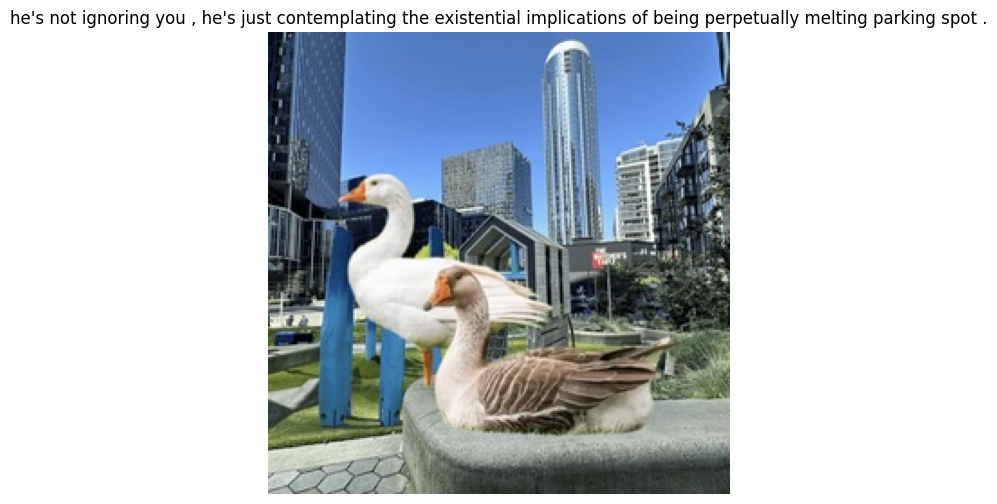

Image: Screenshot 2025-06-03 at 3.49.49 PM.jpg
Caption: he's not ignoring you , he's just contemplating the existential implications of being perpetually melting parking spot .
----------------------------------------


In [12]:
from PIL import Image
import os
import torch
import numpy as np
import torchvision.transforms as T
import matplotlib.pyplot as plt

# Define your two transforms (you already have shitty_transform; here we assume
# `transform` is your model’s preprocessing, add ToTensor/Normalize there too)

shitty_transform = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

image_dir = "demo_images"
image_paths = [
    os.path.join(image_dir, f)
    for f in os.listdir(image_dir)
    if f.lower().endswith(('.png', '.jpg', '.jpeg'))
]

model.eval()

for img_path in image_paths:
    with torch.no_grad():
        # 1) Load and convert
        img_pil = Image.open(img_path).convert('RGB')

        # 2) Center-crop to square
        w, h = img_pil.size
        m = min(w, h)
        left = (w - m) // 2
        top  = (h - m) // 2
        img_pil = img_pil.crop((left, top, left + m, top + m))

        # 3) Apply your transforms
        img_tensor       = transform(img_pil).unsqueeze(0).to(device)
        shitty_img_tensor = shitty_transform(img_pil).unsqueeze(0).to(device)

        # 4) Generate caption
        token_ids = model.sample(img_tensor, max_len=20)[0].cpu().tolist()
        tokens = []
        for tid in token_ids[1:]:  # skip <start>
            tok = tokenizer.itos[tid]
            if tok == "<end>": break
            tokens.append(tok)
        caption = " ".join(tokens)

        # 5) Prepare for display
        img_np = shitty_img_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy()
        img_np = img_np * np.array([0.229, 0.224, 0.225]) + \
                 np.array([0.485, 0.456, 0.406])
        img_np = np.clip(img_np, 0, 1)

    # 6) Show
    plt.figure(figsize=(6, 6))
    plt.imshow(img_np)
    plt.title(caption, fontsize=12)
    plt.axis('off')
    plt.show()

    print(f"Image: {os.path.basename(img_path)}")
    print(f"Caption: {caption}\n{'-'*40}")
